In [1]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import utils, datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
# Set random seed for reproducibility
torch.manual_seed(0)

In [3]:
# Root directory for dataset
dataroot = "data/mnist"

# Number of workers for dataloader
workers = 10

# Batch size during training
batch_size = 512

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 30

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [4]:
import zipfile

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('data1')

In [5]:
from torchvision import datasets, transforms

# 修改这里为你实际的数据文件夹路径
dataroot = 'data1'

# 定义数据变换
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# 创建自定义数据集
dataset = datasets.ImageFolder(root=dataroot, transform=transform)

# 打印数据集大小
print(f'Total Size of Dataset: {len(dataset)}')


Total Size of Dataset: 21551


In [6]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

In [7]:
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

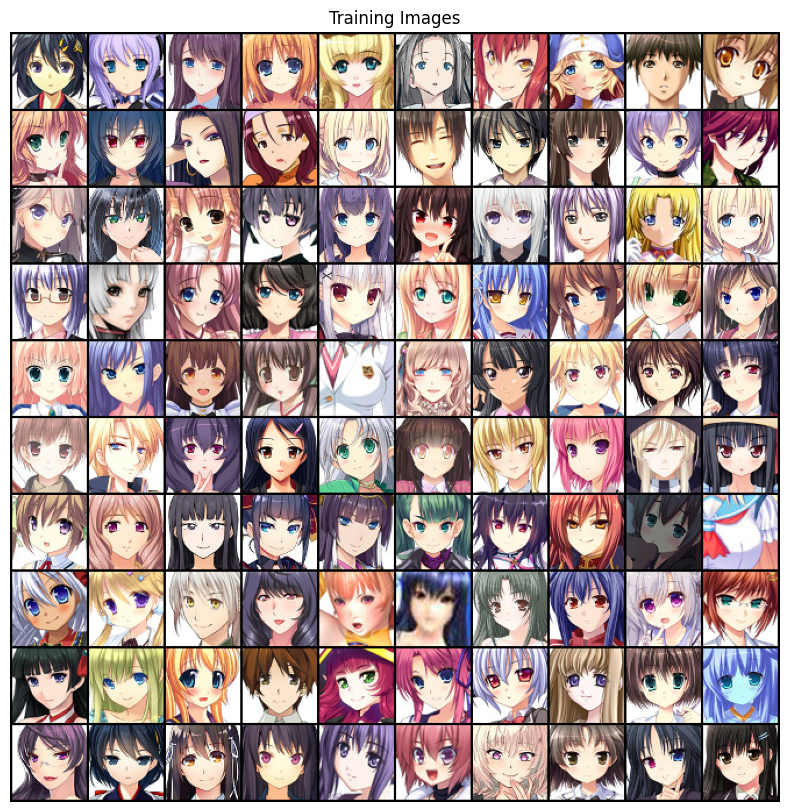

In [8]:
inputs = next(iter(dataloader))[0]
plt.figure(figsize=(10,10))
plt.title("Training Images")
plt.axis('off')
inputs = utils.make_grid(inputs[:100]*0.5+0.5, nrow=10)
plt.imshow(inputs.permute(1, 2, 0))

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if device.type == 'cuda' and ngpu > 1:
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # state size. (1) x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if device.type == 'cuda' and ngpu > 1:
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [14]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(100, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_x_list = []
D_z_list = []
loss_tep = 10

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    beg_time = time.time()
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        end_time = time.time()
        run_time = round(end_time-beg_time)
        print(
            f'Epoch: [{epoch+1:0>{len(str(num_epochs))}}/{num_epochs}]',
            f'Step: [{i+1:0>{len(str(len(dataloader)))}}/{len(dataloader)}]',
            f'Loss-D: {errD.item():.4f}',
            f'Loss-G: {errG.item():.4f}',
            f'D(x): {D_x:.4f}',
            f'D(G(z)): [{D_G_z1:.4f}/{D_G_z2:.4f}]',
            f'Time: {run_time}s',
            end='\r'
        )
        with open('output.txt', 'a') as f:
          f.write(
              f'Epoch: [{epoch+1:0>{len(str(num_epochs))}}/{num_epochs}] ' +
              f'Step: [{i+1:0>{len(str(len(dataloader)))}}/{len(dataloader)}] ' +
              f'Loss-D: {errD.item():.4f} ' +
              f'Loss-G: {errG.item():.4f} ' +
              f'D(x): {D_x:.4f} ' +
              f'D(G(z)): [{D_G_z1:.4f}/{D_G_z2:.4f}] ' +
              f'Time: {run_time}s\n'
          )
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Save D(X) and D(G(z)) for plotting later
        D_x_list.append(D_x)
        D_z_list.append(D_G_z2)

        # Save the Best Model
        if errG < loss_tep:
            torch.save(netG.state_dict(), 'model.pt')
            loss_tep = errG

    # Check how the generator is doing by saving G's output on fixed_noise
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(utils.make_grid(fake*0.5+0.5, nrow=10))
    print()

Starting Training Loop...
Epoch: [01/30] Step: [43/43] Loss-D: 6.3565 Loss-G: 19.1217 D(x): 0.9199 D(G(z)): [0.9822/0.0000] Time: 6s
Epoch: [02/30] Step: [43/43] Loss-D: 1.2913 Loss-G: 7.5613 D(x): 0.7675 D(G(z)): [0.3933/0.0013] Time: 5ss
Epoch: [03/30] Step: [43/43] Loss-D: 0.5398 Loss-G: 5.6476 D(x): 0.7162 D(G(z)): [0.0476/0.0117] Time: 5s
Epoch: [04/30] Step: [43/43] Loss-D: 0.6186 Loss-G: 4.6458 D(x): 0.7704 D(G(z)): [0.2186/0.0139] Time: 5ss
Epoch: [05/30] Step: [43/43] Loss-D: 0.9787 Loss-G: 4.0086 D(x): 0.5033 D(G(z)): [0.0215/0.0312] Time: 5ss
Epoch: [06/30] Step: [43/43] Loss-D: 0.9561 Loss-G: 5.9455 D(x): 0.7128 D(G(z)): [0.2993/0.0045] Time: 5ss
Epoch: [07/30] Step: [43/43] Loss-D: 0.6902 Loss-G: 4.8682 D(x): 0.6266 D(G(z)): [0.0184/0.0112] Time: 5s
Epoch: [08/30] Step: [43/43] Loss-D: 1.0499 Loss-G: 10.6216 D(x): 0.9502 D(G(z)): [0.5490/0.0001] Time: 5s
Epoch: [09/30] Step: [43/43] Loss-D: 0.6639 Loss-G: 6.3426 D(x): 0.8338 D(G(z)): [0.3372/0.0031] Time: 5ss
Epoch: [10/30

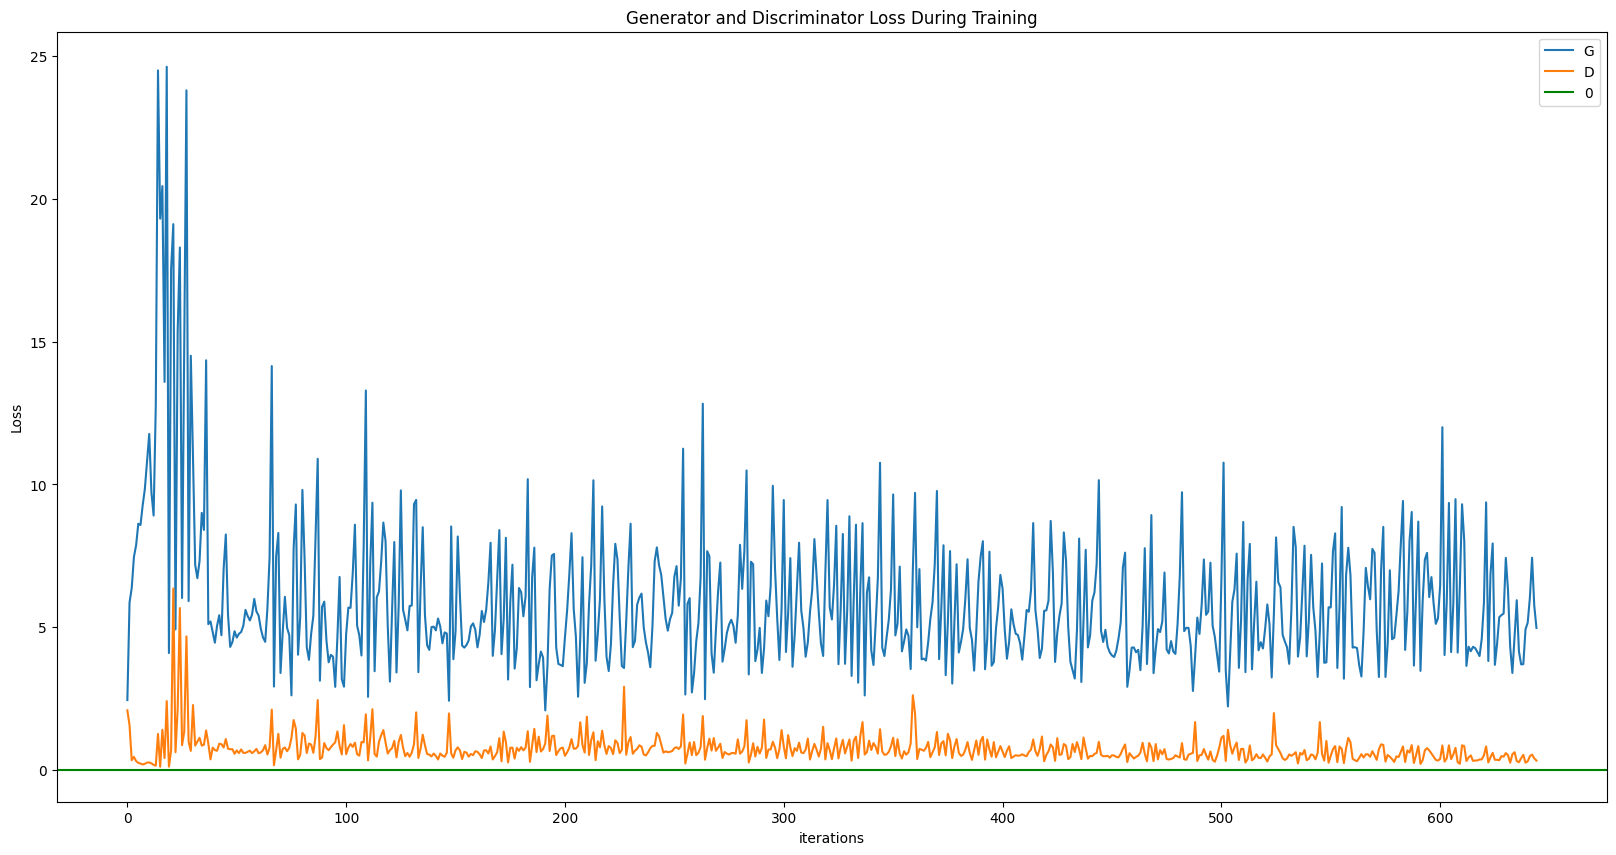

In [16]:
plt.figure(figsize=(20, 10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[::2], label="G")
plt.plot(D_losses[::2], label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.axhline(y=0, label="0", c="g") # asymptote
plt.legend()

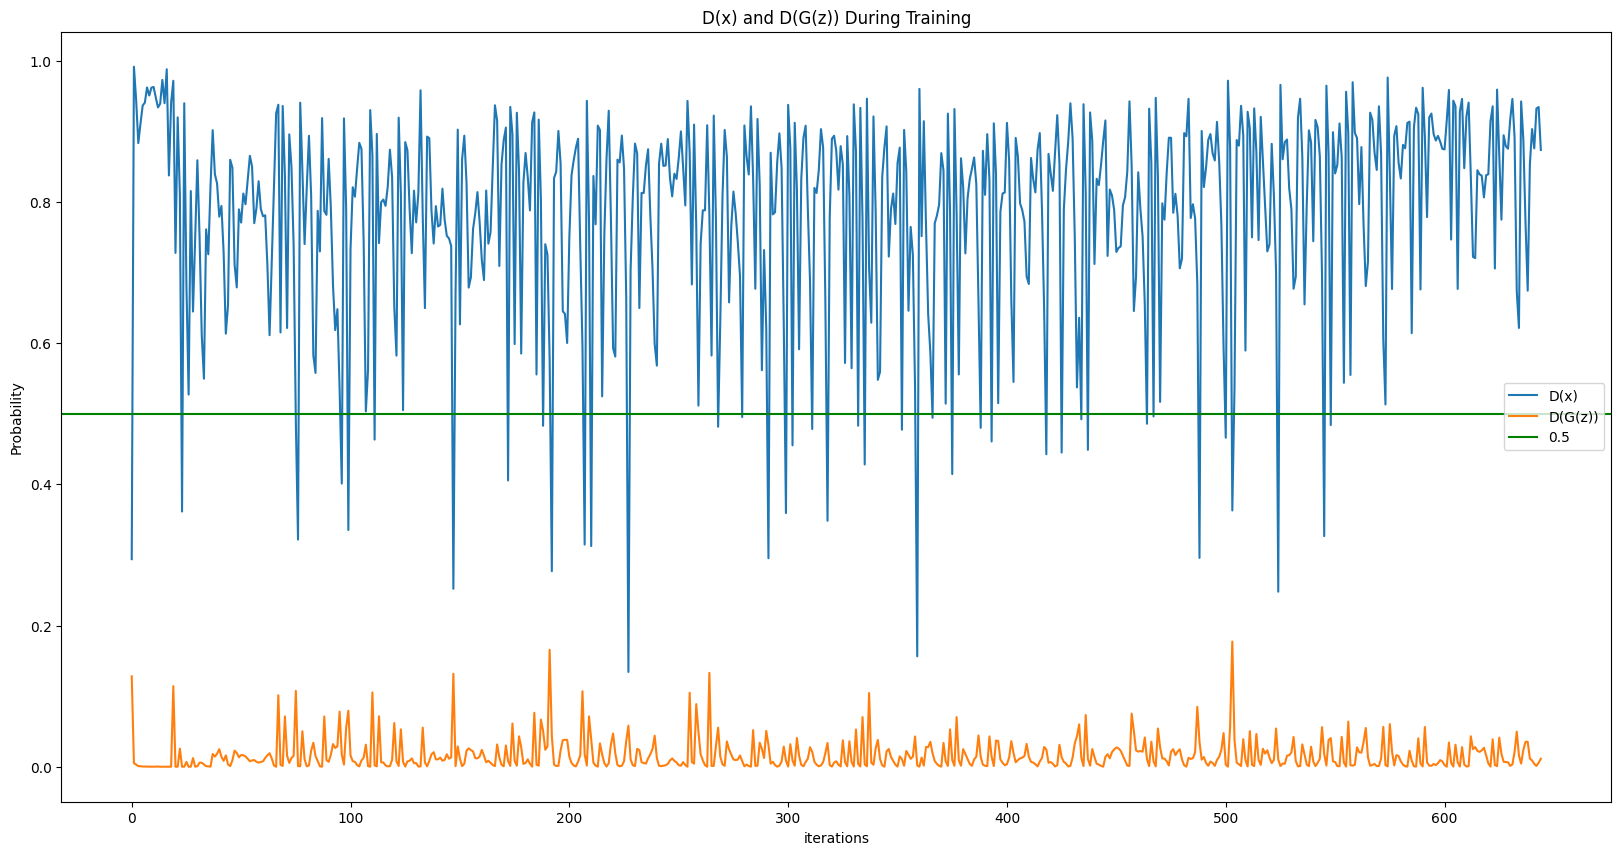

In [17]:
plt.figure(figsize=(20, 10))
plt.title("D(x) and D(G(z)) During Training")
plt.plot(D_x_list[::2], label="D(x)")
plt.plot(D_z_list[::2], label="D(G(z))")
plt.xlabel("iterations")
plt.ylabel("Probability")
plt.axhline(y=0.5, label="0.5", c="g") # asymptote
plt.legend()

In [ ]:
# 创建一个图形对象
fig = plt.figure(figsize=(10, 10))

# 关闭坐标轴
plt.axis("off")

# 将图像列表中的每个图像转换为可动画的对象
ims = [[plt.imshow(item.permute(1, 2, 0), animated=True)] for item in img_list]

# 创建艺术家动画对象
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)


# 保存每帧图像到 "pic" 文件夹
for i, frame in enumerate(img_list):
    plt.imshow(frame.permute(1, 2, 0))
    plt.axis("off")
    plt.savefig(f"pic/frame_{i}.png")
    plt.close()

# 使用HTML显示动画
HTML(ani.to_jshtml())

Animation size has reached 22872883 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


In [ ]:
# Size of the Figure
plt.figure(figsize=(20,10))

# Plot the real images
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
real = next(iter(dataloader))
plt.imshow(utils.make_grid(real[0][:100]*0.5+0.5, nrow=10).permute(1, 2, 0))

# Load the Best Generative Model
netG = Generator(0)
netG.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
netG.eval()

# Generate the Fake Images
with torch.no_grad():
    fake = netG(fixed_noise.cpu())

# Plot the fake images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
fake = utils.make_grid(fake*0.5+0.5, nrow=10)
plt.imshow(fake.permute(1, 2, 0))

# Save the comparation result
plt.savefig('result.jpg', bbox_inches='tight')

In [ ]:
import zipfile
import os

def zip_folder(folder_path, zip_filename):
    # 创建一个Zip文件对象
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # 遍历文件夹内的所有文件并添加到Zip文件
        for foldername, subfolders, filenames in os.walk(folder_path):
            for filename in filenames:
                file_path = os.path.join(foldername, filename)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# 调用函数，压缩文件夹
folder_to_compress = 'pic'  # 替换为你的文件夹路径
zip_filename = 'pic.zip'  # 替换为你的压缩文件名

zip_folder(folder_to_compress, zip_filename)